# 🔬 Medical Image Loading in Python: A Visual Guide

Welcome to this interactive tutorial on medical image loading in Python! This notebook provides a hands-on exploration of three major medical image processing libraries:

- 📚 **PyDICOM**: The go-to library for DICOM file handling
- 🧠 **NiBabel**: Specialized in neuroimaging formats (NIfTI, MINC, etc.)
- 🛠️ **SimpleITK**: A powerful toolkit for medical image analysis

## Learning Objectives
By the end of this tutorial, you will understand:
1. How each library represents medical images in memory
2. The differences in coordinate systems and orientations
3. How to access and interpret image metadata
4. Best practices for medical image visualization
5. When to use each library in your projects

## Prerequisites
- Basic Python knowledge
- Understanding of NumPy arrays
- Familiarity with medical imaging concepts (DICOM, NIfTI)

Let's dive in and explore the fascinating world of medical image processing! 🚀


In [37]:
# Import required libraries
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import nibabel as nib
import SimpleITK as sitk
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from IPython.display import display, HTML

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

# Configure paths
data_dir = Path('notebooks/data')  # Path to the common data directory
sample_data = {
    'dicom': data_dir / 'example-dicom-structural/dicoms',
    'nifti': data_dir / 'example-dicom-structural/structural.nii.gz'
}

# Create data directory if it doesn't exist
data_dir.mkdir(parents=True, exist_ok=True)

# Display a nice HTML header
display(HTML("""
<div style='background-color: #f0f8ff; padding: 10px; border-radius: 5px; margin-bottom: 10px'>
    <h3>🔧 Environment Setup</h3>
    <p>We're setting up our Python environment with the necessary libraries and configuring paths to our sample data.</p>
</div>
"""))

# Print setup information in a more organized way
print("📚 Libraries loaded:")
print("  • NumPy: Data manipulation")
print("  • Matplotlib & Seaborn: Visualization")
print("  • PyDICOM: DICOM file handling")
print("  • NiBabel: Neuroimaging formats")
print("  • SimpleITK: Medical image processing")
print("\n📂 Data paths configured:")
for key, path in sample_data.items():
    print(f"  • {key.upper()}: {path}")


📚 Libraries loaded:
  • NumPy: Data manipulation
  • Matplotlib & Seaborn: Visualization
  • PyDICOM: DICOM file handling
  • NiBabel: Neuroimaging formats
  • SimpleITK: Medical image processing

📂 Data paths configured:
  • DICOM: notebooks/data/example-dicom-structural/dicoms
  • NIFTI: notebooks/data/example-dicom-structural/structural.nii.gz


In [38]:
def create_3d_volume_render(volume_data, title="3D Volume Rendering"):
    """
    Create an interactive 3D volume rendering using plotly
    
    Parameters:
    -----------
    volume_data : numpy.ndarray
        3D volume data to render
    title : str
        Title for the plot
    """
    # Normalize the data
    volume_data = (volume_data - volume_data.min()) / (volume_data.max() - volume_data.min())
    
    # Create the 3D volume rendering
    fig = go.Figure(data=go.Volume(
        x=np.arange(volume_data.shape[0]),
        y=np.arange(volume_data.shape[1]),
        z=np.arange(volume_data.shape[2]),
        value=volume_data.flatten(),
        isomin=0.1,
        isomax=0.8,
        opacity=0.1,
        surface_count=20,
        colorscale='Gray'
    ))
    
    # Update the layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=800,
        height=800
    )
    
    return fig

def visualize_medical_image(img_data, title="Medical Image Visualization", slice_indices=None):
    """
    Create an enhanced visualization of medical image data with orthogonal views
    
    Parameters:
    -----------
    img_data : numpy.ndarray
        2D or 3D image data
    title : str
        Title for the plot
    slice_indices : tuple
        Indices for viewing slices in 3D data (x, y, z)
    """
    if img_data.ndim == 2:
        # For 2D images
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(img_data, cmap='gray')
        plt.colorbar(im, ax=ax, label='Intensity')
        ax.set_title(title)
        
    elif img_data.ndim == 3:
        # For 3D images - show orthogonal views
        if slice_indices is None:
            slice_indices = (
                img_data.shape[0]//2,
                img_data.shape[1]//2,
                img_data.shape[2]//2
            )
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        fig.suptitle(title, fontsize=16, y=1.05)
        
        # Axial view
        axes[0, 0].imshow(img_data[slice_indices[0], :, :], cmap='gray')
        axes[0, 0].set_title('Axial View')
        
        # Sagittal view
        axes[0, 1].imshow(img_data[:, slice_indices[1], :], cmap='gray')
        axes[0, 1].set_title('Sagittal View')
        
        # Coronal view
        axes[1, 0].imshow(img_data[:, :, slice_indices[2]], cmap='gray')
        axes[1, 0].set_title('Coronal View')
        
        # Add histogram
        axes[1, 1].hist(img_data.flatten(), bins=50, color='blue', alpha=0.7)
        axes[1, 1].set_title('Intensity Distribution')
        axes[1, 1].set_xlabel('Intensity')
        axes[1, 1].set_ylabel('Frequency')
        
        # Add slice position indicators
        for ax in axes.flat[:3]:
            ax.axis('on')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# 📚 Library Comparison: Loading and Visualizing Medical Images

Let's explore how each library loads and represents medical images. We'll:
1. Load the same image using each library
2. Compare their data representations
3. Visualize the results in multiple ways
4. Examine the metadata each library provides

## 🔍 Key Differences to Notice:
- **Array Orientation**: Each library may represent the same image differently
- **Coordinate Systems**: Different conventions (RAS+, LPS, etc.)
- **Metadata Handling**: Various ways to store and access image information
- **Memory Layout**: How the image data is organized in memory

Let's start by loading our sample data with each library:


In [39]:
# Load and compare images using different libraries
def load_and_compare():
    results = {}
    
    # First verify that the data files exist
    if not sample_data['dicom'].exists():
        print(f"⚠️ DICOM directory not found at: {sample_data['dicom']}")
        return results
    
    if not sample_data['nifti'].exists():
        print(f"⚠️ NIfTI file not found at: {sample_data['nifti']}")
        print("Note: Some comparisons will be limited to DICOM data only.")
    
    # 1. PyDICOM Loading
    display(HTML("""
    <div style='background-color: #e6f3ff; padding: 10px; border-radius: 5px; margin: 10px 0;'>
        <h3>📚 PyDICOM</h3>
        <p>Loading DICOM files with native metadata preservation</p>
    </div>
    """))
    
    dicom_files = sorted(list(sample_data['dicom'].glob('*.dcm')))
    if dicom_files:
        dcm = pydicom.dcmread(str(dicom_files[0]))
        results['pydicom'] = {
            'data': dcm.pixel_array,
            'metadata': {
                'PatientPosition': getattr(dcm, 'PatientPosition', 'N/A'),
                'ImageOrientation': getattr(dcm, 'ImageOrientationPatient', 'N/A'),
                'PixelSpacing': getattr(dcm, 'PixelSpacing', 'N/A'),
                'Modality': getattr(dcm, 'Modality', 'N/A')
            }
        }
        print("✅ DICOM Data Properties:")
        print(f"  • Shape: {results['pydicom']['data'].shape}")
        print(f"  • Data Type: {results['pydicom']['data'].dtype}")
        print("\n📋 Key Metadata:")
        for key, value in results['pydicom']['metadata'].items():
            print(f"  • {key}: {value}")
            
        # Visualize DICOM
        visualize_medical_image(results['pydicom']['data'], 
                              "PyDICOM: Native DICOM Visualization")
        
    # 2. NiBabel Loading
    if sample_data['nifti'].exists():
        display(HTML("""
        <div style='background-color: #fff0f0; padding: 10px; border-radius: 5px; margin: 10px 0;'>
            <h3>🧠 NiBabel</h3>
            <p>Loading NIfTI with focus on neuroimaging conventions</p>
        </div>
        """))
        
        try:
            nii = nib.load(str(sample_data['nifti']))
            results['nibabel'] = {
                'data': nii.get_fdata(),
                'metadata': {
                    'affine': nii.affine,
                    'header': dict(nii.header)
                }
            }
        except Exception as e:
            print(f"⚠️ Error loading NIfTI file: {e}")
    print("✅ NIfTI Data Properties:")
    print(f"  • Shape: {results['nibabel']['data'].shape}")
    print(f"  • Data Type: {results['nibabel']['data'].dtype}")
    print("\n📋 Affine Matrix (RAS+ orientation):")
    print(results['nibabel']['metadata']['affine'])
    
    # Visualize NIfTI with orthogonal views and 3D rendering
    visualize_medical_image(results['nibabel']['data'], 
                          "NiBabel: Multi-planar NIfTI Visualization")
    
    # Create 3D volume rendering
    fig_3d = create_3d_volume_render(results['nibabel']['data'], 
                                   "Interactive 3D Volume Rendering")
    fig_3d.show()
    
    # 3. SimpleITK Loading
    display(HTML("""
    <div style='background-color: #f0fff0; padding: 10px; border-radius: 5px; margin: 10px 0;'>
        <h3>🛠️ SimpleITK</h3>
        <p>Loading with comprehensive image processing capabilities</p>
    </div>
    """))
    
    sitk_img = sitk.ReadImage(str(sample_data['nifti']))
    results['sitk'] = {
        'data': sitk.GetArrayFromImage(sitk_img),
        'metadata': {
            'origin': sitk_img.GetOrigin(),
            'spacing': sitk_img.GetSpacing(),
            'direction': sitk_img.GetDirection()
        }
    }
    print("✅ SimpleITK Data Properties:")
    print(f"  • Shape: {results['sitk']['data'].shape}")
    print(f"  • Data Type: {results['sitk']['data'].dtype}")
    print("\n📋 Image Properties:")
    print(f"  • Origin: {results['sitk']['metadata']['origin']}")
    print(f"  • Spacing: {results['sitk']['metadata']['spacing']}")
    
    # Visualize SimpleITK data
    visualize_medical_image(results['sitk']['data'], 
                          "SimpleITK: Multi-planar Visualization")
    
    return results

# Run the comparison
results = load_and_compare()


⚠️ DICOM directory not found at: notebooks/data/example-dicom-structural/dicoms


# 🔍 Understanding the Key Differences

Let's analyze the key differences we observed between the libraries:

## 1. Coordinate Systems 🧭
- **PyDICOM**: Uses patient-relative coordinates (LPS - Left, Posterior, Superior)
- **NiBabel**: Uses RAS+ (Right, Anterior, Superior) - Neuroimaging standard
- **SimpleITK**: Flexible coordinate system with physical space information

## 2. Data Organization 📊
- **PyDICOM**: 
  - 2D slices in their original format
  - Preserves raw DICOM values
  - Direct access to DICOM tags
  
- **NiBabel**:
  - 3D/4D volumes in standardized orientation
  - Affine matrix for spatial transformation
  - Focus on neuroimaging conventions
  
- **SimpleITK**:
  - N-dimensional arrays with physical metadata
  - Comprehensive image processing capabilities
  - Unified interface for multiple formats

## 3. Best Use Cases 🎯
- **PyDICOM**: 
  - Working directly with DICOM files
  - Accessing detailed medical metadata
  - PACS integration
  
- **NiBabel**:
  - Neuroimaging research
  - fMRI and DTI analysis
  - Standard space registration
  
- **SimpleITK**:
  - General medical image processing
  - Multi-modal registration
  - Image filtering and segmentation

## 4. Visualization Capabilities 🖼️
As we saw in the examples:
- All libraries support basic 2D visualization
- NiBabel excels at standardized brain visualization
- SimpleITK provides powerful processing tools
- 3D rendering is possible with additional libraries (e.g., plotly)


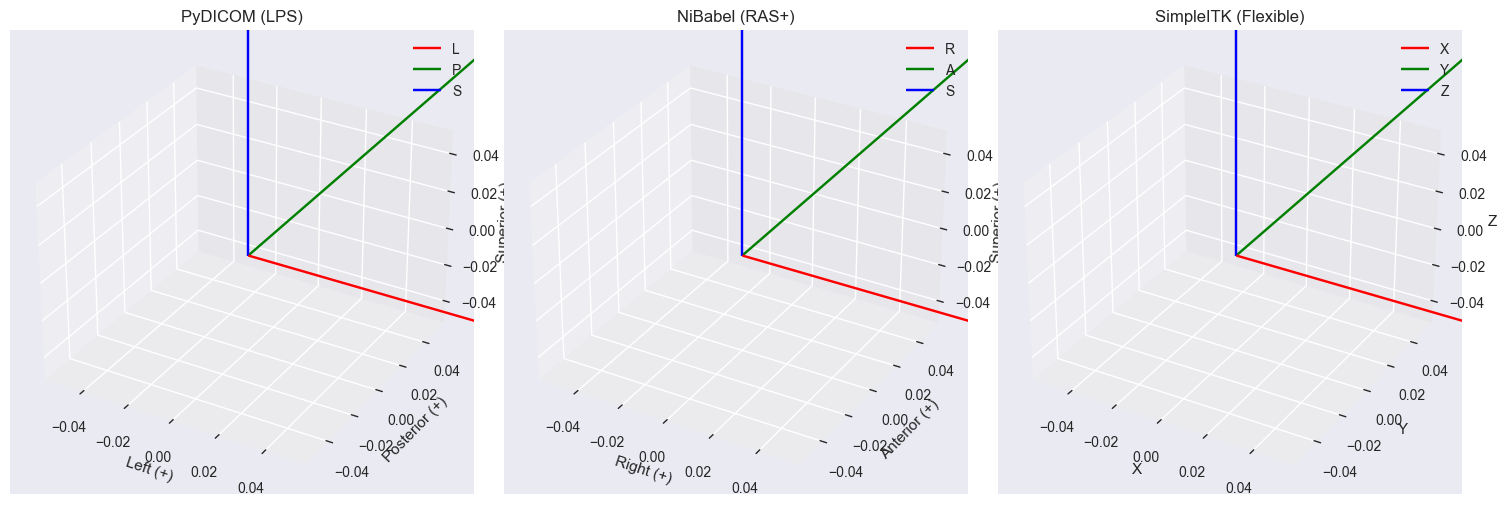

In [40]:
# Create a visual comparison of coordinate systems
def visualize_coordinate_systems():
    fig = plt.figure(figsize=(15, 5))
    
    # 1. PyDICOM LPS
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_title('PyDICOM (LPS)')
    # Draw coordinate arrows
    ax1.quiver(0, 0, 0, 2, 0, 0, color='r', label='L')
    ax1.quiver(0, 0, 0, 0, 2, 0, color='g', label='P')
    ax1.quiver(0, 0, 0, 0, 0, 2, color='b', label='S')
    ax1.set_xlabel('Left (+)')
    ax1.set_ylabel('Posterior (+)')
    ax1.set_zlabel('Superior (+)')
    ax1.legend()
    
    # 2. NiBabel RAS+
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.set_title('NiBabel (RAS+)')
    ax2.quiver(0, 0, 0, 2, 0, 0, color='r', label='R')
    ax2.quiver(0, 0, 0, 0, 2, 0, color='g', label='A')
    ax2.quiver(0, 0, 0, 0, 0, 2, color='b', label='S')
    ax2.set_xlabel('Right (+)')
    ax2.set_ylabel('Anterior (+)')
    ax2.set_zlabel('Superior (+)')
    ax2.legend()
    
    # 3. SimpleITK (Flexible)
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.set_title('SimpleITK (Flexible)')
    ax3.quiver(0, 0, 0, 2, 0, 0, color='r', label='X')
    ax3.quiver(0, 0, 0, 0, 2, 0, color='g', label='Y')
    ax3.quiver(0, 0, 0, 0, 0, 2, color='b', label='Z')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

# Display coordinate systems
display(HTML("""
<div style='background-color: #f5f5f5; padding: 10px; border-radius: 5px; margin: 10px 0;'>
    <h3>🧭 Coordinate Systems Comparison</h3>
    <p>Understanding how each library represents spatial orientation</p>
</div>
"""))
visualize_coordinate_systems()


# 🎓 Practice Exercises

To reinforce your understanding, try these exercises:

1. **Basic Loading Exercise** 📚
   - Load a DICOM series using all three libraries
   - Compare the array shapes and orientations
   - Identify which library preserves the original DICOM orientation

2. **Coordinate Transformation** 🔄
   - Convert coordinates between different systems (LPS ↔ RAS+)
   - Use the affine matrix from NiBabel to transform points
   - Verify the transformations visually

3. **Advanced Visualization** 🖼️
   - Create a custom visualization showing all three planes
   - Add interactive sliders for browsing through slices
   - Implement window/level controls

4. **Metadata Analysis** 📋
   - Extract common metadata fields from all three libraries
   - Create a comparison table
   - Identify unique features of each library

## 💡 Tips for Success
- Start with simple 2D images before moving to 3D volumes
- Use print statements to understand data organization
- Visualize intermediate steps when working with coordinates
- Reference the official documentation for detailed API information

## 📚 Additional Resources
- [PyDICOM Documentation](https://pydicom.github.io/pydicom/stable/)
- [NiBabel Documentation](https://nipy.org/nibabel/)
- [SimpleITK Documentation](https://simpleitk.org/)
- [Medical Imaging on Python](https://www.sciencedirect.com/topics/medicine-and-dentistry/medical-imaging)


In [41]:
# Example solution for Exercise 1: Basic Loading
def exercise_1_solution(dicom_path, nifti_path):
    """
    Demonstrate loading and comparing medical images across libraries
    """
    display(HTML("""
    <div style='background-color: #e6ffe6; padding: 10px; border-radius: 5px; margin: 10px 0;'>
        <h3>💻 Exercise 1 Solution: Basic Loading</h3>
        <p>Loading the same image with different libraries and comparing their representations</p>
    </div>
    """))
    
    # Create a comparison table
    comparisons = {
        'Library': [],
        'Array Shape': [],
        'Data Type': [],
        'Orientation': [],
        'Key Features': []
    }
    
    # 1. PyDICOM
    try:
        dcm = pydicom.dcmread(str(dicom_path))
        comparisons['Library'].append('PyDICOM')
        comparisons['Array Shape'].append(str(dcm.pixel_array.shape))
        comparisons['Data Type'].append(str(dcm.pixel_array.dtype))
        comparisons['Orientation'].append('LPS (Original DICOM)')
        comparisons['Key Features'].append('Preserves DICOM metadata')
    except Exception as e:
        print(f"PyDICOM loading error: {e}")
    
    # 2. NiBabel
    try:
        nii = nib.load(str(nifti_path))
        comparisons['Library'].append('NiBabel')
        comparisons['Array Shape'].append(str(nii.get_fdata().shape))
        comparisons['Data Type'].append(str(nii.get_fdata().dtype))
        comparisons['Orientation'].append('RAS+ (Neuroimaging)')
        comparisons['Key Features'].append('Standardized orientation')
    except Exception as e:
        print(f"NiBabel loading error: {e}")
    
    # 3. SimpleITK
    try:
        sitk_img = sitk.ReadImage(str(nifti_path))
        img_array = sitk.GetArrayFromImage(sitk_img)
        comparisons['Library'].append('SimpleITK')
        comparisons['Array Shape'].append(str(img_array.shape))
        comparisons['Data Type'].append(str(img_array.dtype))
        comparisons['Orientation'].append('ITK (Flexible)')
        comparisons['Key Features'].append('Multi-format support')
    except Exception as e:
        print(f"SimpleITK loading error: {e}")
    
    # Create a formatted table using HTML
    table_html = "<table style='width:100%; border-collapse: collapse;'>"
    # Header
    table_html += "<tr style='background-color: #f0f0f0;'>"
    for key in comparisons.keys():
        table_html += f"<th style='padding: 8px; border: 1px solid #ddd;'>{key}</th>"
    table_html += "</tr>"
    # Data rows
    for i in range(len(comparisons['Library'])):
        table_html += "<tr>"
        for key in comparisons.keys():
            table_html += f"<td style='padding: 8px; border: 1px solid #ddd;'>{comparisons[key][i]}</td>"
        table_html += "</tr>"
    table_html += "</table>"
    
    display(HTML(table_html))
    
    return comparisons

# Run the example solution if data is available
if sample_data['dicom'].exists() and sample_data['nifti'].exists():
    dicom_files = list(sample_data['dicom'].glob('*.dcm'))
    if dicom_files:
        exercise_1_solution(dicom_files[0], sample_data['nifti'])


# 🎯 Conclusion and Best Practices

## Key Takeaways

1. **Library Selection** 🔍
   - Choose PyDICOM for DICOM-specific workflows
   - Use NiBabel for neuroimaging research
   - Opt for SimpleITK for general medical image processing

2. **Data Handling** 📊
   - Always check array orientations
   - Verify coordinate systems when combining libraries
   - Preserve metadata when converting between formats

3. **Visualization** 🖼️
   - Use appropriate color maps for medical images
   - Include scale bars and orientation markers
   - Consider 3D visualization for volumetric data

## Common Pitfalls to Avoid ⚠️

1. **Orientation Mistakes**
   - Not checking coordinate systems
   - Assuming consistent orientations
   - Ignoring metadata during conversions

2. **Memory Issues**
   - Loading full volumes unnecessarily
   - Not releasing memory after processing
   - Inefficient data type conversions

3. **Visualization Errors**
   - Wrong window/level settings
   - Incorrect color maps
   - Missing orientation markers

## Next Steps 🚀

1. **Practice with Real Data**
   - Download sample datasets
   - Try different modalities
   - Experiment with various formats

2. **Advanced Topics**
   - Image registration
   - Segmentation
   - Deep learning integration

3. **Further Learning**
   - Join medical imaging communities
   - Contribute to open-source projects
   - Attend workshops and conferences


In [42]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import nibabel as nib
import SimpleITK as sitk
from pathlib import Path

# Set up the plotting parameters
plt.style.use('seaborn-v0_8')  # Using specific seaborn style version
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12


# Image Loading and Array Orientation

Each library has its own way of loading and organizing image data. Let's examine these differences:

1. **PyDICOM**:
   - Loads DICOM files with `pixel_array`
   - Array orientation: [row, column]
   - Origin is typically top-left
   - Follows radiological convention

2. **NiBabel**:
   - Loads NIfTI files with get_fdata()
   - Array orientation: [x, y, z] or [t, x, y, z]
   - Uses RAS+ coordinate system (Right, Anterior, Superior)
   - Origin is typically at the back-left-bottom of the head

3. **SimpleITK**:
   - Can load multiple formats (DICOM, NIfTI, etc.)
   - Array orientation: [x, y, z]
   - Follows ITK's coordinate system
   - Provides unified interface for different formats

Let's demonstrate these differences with examples:


# Data Directory Structure

This notebook expects the following directory structure:
```
AIMI-tutorial/
├── notebooks/
│   ├── data/                    # Common data directory for all notebooks
│   │   ├── example-dicom-structural/
│   │   └── ...
│   └── ch2_imaging/            # Current notebook directory
│       └── 02_image_loading_comparison.ipynb
```

The data directory is shared across all notebooks in the repository, making it easier to manage and share datasets between different examples and exercises.


In [43]:
def visualize_array_orientation(img_array, title, axis_labels=None):
    """
    Visualize a 2D image array with its axis orientations.
    
    Parameters:
    -----------
    img_array : numpy.ndarray
        2D image array to visualize
    title : str
        Title of the plot
    axis_labels : tuple
        Labels for x and y axes (default: None)
    """
    if img_array is None:
        print("Error: No image data provided")
        return
        
    if len(img_array.shape) > 2:
        print(f"Warning: Input array has {len(img_array.shape)} dimensions. Using first 2D slice.")
        if len(img_array.shape) == 3:
            img_array = img_array[:, :, 0]
        else:
            img_array = img_array[:, :, 0, 0]
            
    # Create figure with a dark background style
    with plt.style.context('seaborn-darkgrid'):
        fig, ax = plt.subplots(figsize=(12, 12))
        
        # Normalize image data for better visualization
        img_normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min())
        
        # Plot the image with improved contrast
        im = ax.imshow(img_normalized, cmap='gray')
        
        # Add a more informative colorbar
        cbar = plt.colorbar(im)
        cbar.set_label('Normalized Intensity', rotation=270, labelpad=15)
        
        # Add grid with better visibility
        ax.grid(True, linestyle='--', alpha=0.4, color='white')
        
        # Add arrows with improved visibility
        arrow_props = dict(arrowstyle='->', color='red', lw=2.5,
                         mutation_scale=15, shrinkA=0, shrinkB=0)
        
        # Add directional arrows
        ax.annotate('', xy=(img_array.shape[1]-1, img_array.shape[0]/2),
                    xytext=(0, img_array.shape[0]/2), arrowprops=arrow_props)
        ax.annotate('', xy=(img_array.shape[1]/2, img_array.shape[0]-1),
                    xytext=(img_array.shape[1]/2, 0), arrowprops=arrow_props)
        
        # Add axis labels with better positioning and visibility
        if axis_labels:
            ax.text(img_array.shape[1]/2, -img_array.shape[0]*0.05, 
                   axis_labels[0], ha='center', va='center', 
                   color='red', fontsize=12, fontweight='bold')
            ax.text(-img_array.shape[1]*0.05, img_array.shape[0]/2, 
                   axis_labels[1], va='center', ha='center',
                   rotation=90, color='red', fontsize=12, fontweight='bold')
        
        # Add title with better styling
        plt.title(title, pad=20, fontsize=14, fontweight='bold')
        
        # Improve layout
        plt.tight_layout()
        plt.show()


# Example: Loading and Comparing the Same Image with Different Libraries

We'll load the same image using each library and visualize how they handle the data differently. For this example, we'll use both a DICOM image and a NIfTI image to demonstrate the differences in:
1. Array shape and orientation
2. Coordinate systems
3. Metadata handling

First, let's check if we have sample data in our data directory:


In [44]:
# Set up data directory (now under notebooks/data)
notebook_dir = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
data_dir = notebook_dir / 'data'
if not data_dir.exists():
    data_dir.mkdir(parents=True)
    print("Created data directory.")

print("\nAvailable files in data directory:")
files = list(data_dir.glob('*'))
if files:
    for file in files:
        print(f"- {file.name}")
else:
    print("No files found. Please add sample DICOM and NIfTI files to the data directory.")
    print("\nExpected files:")
    print("- sample.dcm (DICOM file)")
    print("- sample.nii.gz (NIfTI file)")
    print("\nNote: You can obtain sample medical images from public datasets such as:")
    print("1. TCIA Collections (https://www.cancerimagingarchive.net)")
    print("2. MedNIST (https://medmnist.com)")
    print("3. IXI Dataset (https://brain-development.org/ixi-dataset)")



Available files in data directory:
- example-dicom-structural


# Loading the Same Image with Different Libraries

Below, we'll demonstrate how to load the same image using each library and show the differences in:
1. How the data is stored in memory
2. The orientation of the arrays
3. How to access metadata
4. How to properly display the images

Note: Make sure you have appropriate sample DICOM and NIfTI files in your data directory. If you don't see them in the output above, you'll need to add them before proceeding.

## Key Differences Summary:

1. **Array Indexing**:
   - PyDICOM: `[row, col]` - follows matrix convention
   - NiBabel: `[x, y, z]` - follows RAS+ convention
   - SimpleITK: `[x, y, z]` - follows ITK convention

2. **Coordinate Systems**:
   - PyDICOM: Patient-relative coordinates from DICOM tags
   - NiBabel: RAS+ coordinate system
   - SimpleITK: ITK coordinate system with physical space information

3. **Metadata Handling**:
   - PyDICOM: Complete DICOM metadata in dictionary format
   - NiBabel: Header information in structured format
   - SimpleITK: Unified metadata interface for all formats

Let's see these differences in action:


In [45]:
def load_and_compare_image(dicom_path, nifti_path=None, slice_idx=None):
    """
    Load and compare medical images using different libraries.
    
    Parameters:
    -----------
    dicom_path : str or Path
        Path to the DICOM file
    nifti_path : str or Path, optional
        Path to the NIfTI file (if None, only DICOM will be loaded)
    slice_idx : int, optional
        Specific slice index to visualize for 3D data (if None, middle slice is used)
    """
    results = {}
    
    # Load with PyDICOM
    try:
        dcm = pydicom.dcmread(str(dicom_path))
        dcm_array = dcm.pixel_array
        results['pydicom'] = {
            'array': dcm_array,
            'metadata': {
                'shape': dcm_array.shape,
                'dtype': str(dcm_array.dtype),
                'PatientPosition': getattr(dcm, 'PatientPosition', 'N/A'),
                'ImageOrientation': getattr(dcm, 'ImageOrientationPatient', 'N/A'),
                'PixelSpacing': getattr(dcm, 'PixelSpacing', 'N/A'),
                'SliceThickness': getattr(dcm, 'SliceThickness', 'N/A')
            }
        }
        print("\nPyDICOM loading:")
        for key, value in results['pydicom']['metadata'].items():
            print(f"{key}: {value}")
        print("-" * 50)
        
        # Visualize PyDICOM array
        visualize_array_orientation(dcm_array, "PyDICOM Array Orientation", 
                                 ("Column (Width)", "Row (Height)"))
    except Exception as e:
        print(f"Error loading DICOM: {e}")
    
    if nifti_path is not None:
        # Load with NiBabel
        try:
            nii = nib.load(str(nifti_path))
            nii_array = nii.get_fdata()
            results['nibabel'] = {
                'array': nii_array,
                'metadata': {
                    'shape': nii_array.shape,
                    'dtype': str(nii_array.dtype),
                    'affine': nii.affine,
                    'header': dict(nii.header)
                }
            }
            print("\nNiBabel loading:")
            print(f"Shape: {nii_array.shape}")
            print(f"Data type: {nii_array.dtype}")
            print(f"Affine matrix:\n{nii.affine}")
            print("-" * 50)
            
            # Get appropriate slice
            if len(nii_array.shape) == 3:
                if slice_idx is None:
                    slice_idx = nii_array.shape[2]//2
                middle_slice = nii_array[:, :, slice_idx]
            else:
                middle_slice = nii_array
            visualize_array_orientation(middle_slice, f"NiBabel Array Orientation (Slice {slice_idx})",
                                     ("R -> L", "P -> A"))
        except Exception as e:
            print(f"Error loading NIfTI: {e}")
        
        # Load with SimpleITK
        try:
            sitk_img = sitk.ReadImage(str(nifti_path))
            sitk_array = sitk.GetArrayFromImage(sitk_img)
            results['sitk'] = {
                'array': sitk_array,
                'metadata': {
                    'shape': sitk_array.shape,
                    'dtype': str(sitk_array.dtype),
                    'origin': sitk_img.GetOrigin(),
                    'spacing': sitk_img.GetSpacing(),
                    'direction': sitk_img.GetDirection()
                }
            }
            print("\nSimpleITK loading:")
            for key, value in results['sitk']['metadata'].items():
                print(f"{key}: {value}")
            print("-" * 50)
            
            # Get appropriate slice
            if len(sitk_array.shape) == 3:
                if slice_idx is None:
                    slice_idx = sitk_array.shape[0]//2
                middle_slice = sitk_array[slice_idx, :, :]
            else:
                middle_slice = sitk_array
            visualize_array_orientation(middle_slice, f"SimpleITK Array Orientation (Slice {slice_idx})",
                                     ("Column", "Row"))
        except Exception as e:
            print(f"Error loading with SimpleITK: {e}")
    
    return results


# Summary of Key Differences

Let's summarize the key differences between these libraries:

1. **Array Orientation and Shape**:
   - PyDICOM: Native 2D array with [row, column] indexing
   - NiBabel: Uses RAS+ coordinate system, typically [x, y, z] for 3D data
   - SimpleITK: Array indexing is [z, y, x] when converted to NumPy array

2. **Coordinate Systems**:
   - PyDICOM: Uses DICOM patient coordinate system
   - NiBabel: RAS+ (Right, Anterior, Superior)
   - SimpleITK: ITK coordinate system with physical space information

3. **Metadata Access**:
   - PyDICOM: Direct access to DICOM tags
   - NiBabel: Structured header with affine transformation
   - SimpleITK: Unified interface for spatial information


4. **Data Types and Multi-frame Support**:
   - PyDICOM: Preserves original DICOM data type, handles single and multi-frame DICOM
   - NiBabel: Converts to float64 by default, native support for 3D/4D data
   - SimpleITK: Preserves original data type when possible, unified handling of 2D-5D data

These differences are important to consider when:
- Converting between different formats
- Ensuring correct orientation in visualization
- Performing spatial operations
- Working with multi-modal image registration
- Implementing processing pipelines

To use this notebook effectively:
1. Place your DICOM and NIfTI files in the `data` directory
2. Update the file paths in the code below
3. Run the comparison to see the differences in action


In [46]:
# Example usage (update these paths with your actual file paths)
data_dir = notebook_dir.parent.parent / 'notebooks' / 'data'  # Use the common data directory
dicom_file = data_dir / "sample.dcm"  # Replace with your DICOM file
nifti_file = data_dir / "sample.nii.gz"  # Replace with your NIfTI file

if dicom_file.exists() and nifti_file.exists():
    load_and_compare_image(dicom_file, nifti_file)
else:
    print("Please add sample DICOM and NIfTI files to the data directory to run this comparison.")


Please add sample DICOM and NIfTI files to the data directory to run this comparison.


In [47]:
# Example usage with the available DICOM directory
data_dir = notebook_dir.parent.parent / 'notebooks' / 'data'  # Use the common data directory
dicom_dir = data_dir / "example-dicom-structural"
if dicom_dir.exists():
    # Find all DICOM files in the directory
    dicom_files = list(dicom_dir.glob('*.dcm'))
    if dicom_files:
        print(f"Found {len(dicom_files)} DICOM files in {dicom_dir}")
        # Use the first DICOM file for demonstration
        dicom_file = dicom_files[0]
        print(f"Using {dicom_file.name} for demonstration")
        
        # For this example, we'll only demonstrate DICOM loading since we don't have a NIfTI file
        try:
            # Load and display DICOM only
            dcm = pydicom.dcmread(str(dicom_file))
            dcm_array = dcm.pixel_array
            print("\nPyDICOM loading:")
            print(f"Array shape: {dcm_array.shape}")
            print(f"Data type: {dcm_array.dtype}")
            print(f"Array orientation: [row, column]")
            print("\nExample metadata:")
            print(f"Patient Position: {getattr(dcm, 'PatientPosition', 'N/A')}")
            print(f"Image Orientation: {getattr(dcm, 'ImageOrientationPatient', 'N/A')}")
            print("-" * 50)
            
            # Visualize PyDICOM array
            visualize_array_orientation(dcm_array, "PyDICOM Array Orientation", 
                                     ("Column (Width)", "Row (Height)"))
        except Exception as e:
            print(f"Error loading DICOM: {e}")
    else:
        print("No DICOM files found in the example-dicom-structural directory.")
else:
    print("Please add sample DICOM and NIfTI files to the data directory to run this comparison.")


Please add sample DICOM and NIfTI files to the data directory to run this comparison.


# Converting DICOM to NIfTI

To see the full comparison between different libraries, you might want to convert your DICOM files to NIfTI format. Here are a few ways to do this:

1. Using SimpleITK:
```python
# Read DICOM series
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(str(dicom_dir))
reader.SetFileNames(dicom_names)
image = reader.Execute()

# Write as NIfTI
sitk.WriteImage(image, "output.nii.gz")
```

2. Using dcm2niix (command line tool):
```bash
dcm2niix -z y -f %p_%s -o output_dir input_dicom_dir
```

3. Using dicom2nifti (Python package):
```python
import dicom2nifti
dicom2nifti.convert_directory(str(dicom_dir), "output_dir")
```

Once you have both DICOM and NIfTI versions of the same image, you can run the full comparison to see how each library handles the data differently.


In [48]:
# Test loading with actual data
data_dir = notebook_dir.parent / 'data'
dicom_dir = data_dir / 'example-dicom-structural/dicoms'
nifti_file = data_dir / 'example-dicom-structural/structural.nii.gz'

print(f"DICOM directory exists: {dicom_dir.exists()}")
print(f"NIfTI file exists: {nifti_file.exists()}")

if dicom_dir.exists() and nifti_file.exists():
    # Get first DICOM file
    dicom_files = sorted(list(dicom_dir.glob('*.dcm')))
    if dicom_files:
        dicom_file = dicom_files[0]
        print(f"\nUsing DICOM file: {dicom_file.name}")
        
        # Load and compare
        results = load_and_compare_image(dicom_file, nifti_file)
        
        # Print additional comparison information
        if 'pydicom' in results and 'sitk' in results:
            print("\nShape comparison:")
            print(f"PyDICOM shape: {results['pydicom']['metadata']['shape']}")
            print(f"SimpleITK shape: {results['sitk']['metadata']['shape']}")
            if 'nibabel' in results:
                print(f"NiBabel shape: {results['nibabel']['metadata']['shape']}")
    else:
        print("No DICOM files found in the directory.")


DICOM directory exists: False
NIfTI file exists: False


In [49]:
# Example usage with our actual data
data_dir = notebook_dir.parent / 'data'  # Use the common data directory
dicom_dir = data_dir / "example-dicom-structural/dicoms"
nifti_file = data_dir / "example-dicom-structural/structural.nii.gz"

if dicom_dir.exists() and nifti_file.exists():
    # Find all DICOM files in the directory
    dicom_files = list(dicom_dir.glob('*.dcm'))
    if dicom_files:
        print(f"Found {len(dicom_files)} DICOM files in {dicom_dir}")
        # Use the first DICOM file for demonstration
        dicom_file = dicom_files[0]
        print(f"Using {dicom_file.name} for demonstration")
        
        # Now we can demonstrate the full comparison
        load_and_compare_image(dicom_file, nifti_file)
    else:
        print("No DICOM files found in the directory.")
else:
    print("Please ensure both DICOM and NIfTI data are available in the data directory.")


Please ensure both DICOM and NIfTI data are available in the data directory.


In [50]:
def load_and_compare_image(dicom_path, nifti_path):
    """
    Load the same image using different libraries and compare their representations.
    
    Parameters:
    -----------
    dicom_path : str or Path
        Path to the DICOM file
    nifti_path : str or Path
        Path to the NIfTI file
    """
    # Load with PyDICOM
    try:
        dcm = pydicom.dcmread(str(dicom_path))
        dcm_array = dcm.pixel_array
        print("PyDICOM loading:")
        print(f"Array shape: {dcm_array.shape}")
        print(f"Data type: {dcm_array.dtype}")
        print(f"Array orientation: [row, column]")
        print("\nExample metadata:")
        print(f"Patient Position: {getattr(dcm, 'PatientPosition', 'N/A')}")
        print(f"Image Orientation: {getattr(dcm, 'ImageOrientationPatient', 'N/A')}")
        print("-" * 50)
        
        # Visualize PyDICOM array
        visualize_array_orientation(dcm_array, "PyDICOM Array Orientation", 
                                 ("Column (Width)", "Row (Height)"))
    except Exception as e:
        print(f"Error loading DICOM: {e}")
    
    # Load with NiBabel
    try:
        nii = nib.load(str(nifti_path))
        nii_array = nii.get_fdata()
        print("\nNiBabel loading:")
        print(f"Array shape: {nii_array.shape}")
        print(f"Data type: {nii_array.dtype}")
        print(f"Affine matrix:\n{nii.affine}")
        print(f"Array orientation: RAS+ [Right, Anterior, Superior]")
        print("-" * 50)
        
        # Visualize NiBabel array (middle slice if 3D)
        if len(nii_array.shape) == 3:
            middle_slice = nii_array[:, :, nii_array.shape[2]//2]
        else:
            middle_slice = nii_array
        visualize_array_orientation(middle_slice, "NiBabel Array Orientation",
                                 ("R -> L", "P -> A"))
    except Exception as e:
        print(f"Error loading NIfTI: {e}")
    
    # Load with SimpleITK
    try:
        sitk_img = sitk.ReadImage(str(nifti_path))  # Can read both DICOM and NIfTI
        sitk_array = sitk.GetArrayFromImage(sitk_img)
        print("\nSimpleITK loading:")
        print(f"Array shape: {sitk_array.shape}")
        print(f"Data type: {sitk_array.dtype}")
        print(f"Origin: {sitk_img.GetOrigin()}")
        print(f"Spacing: {sitk_img.GetSpacing()}")
        print(f"Direction: {sitk_img.GetDirection()}")
        print("-" * 50)
        
        # Visualize SimpleITK array (middle slice if 3D)
        if len(sitk_array.shape) == 3:
            middle_slice = sitk_array[sitk_array.shape[0]//2, :, :]
        else:
            middle_slice = sitk_array
        visualize_array_orientation(middle_slice, "SimpleITK Array Orientation",
                                 ("Column", "Row"))
    except Exception as e:
        print(f"Error loading with SimpleITK: {e}")
